<a href="https://colab.research.google.com/github/destello501/destello501.github.io/blob/main/Blind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
#panda nos permite manipular el archivo csv https://pandas.pydata.org
import pandas as pd
#numpy nos permite hacer operaciones usando vectores https://numpy.org
import numpy as np
#plotly nos permite crear graficas interactivas https://plotly.com/python/
import plotly.express as px
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

%matplotlib inline
#usamos la liga que está directamente en la página.
particles = pd.read_csv('https://raw.githubusercontent.com/ProgramasParaFisicaDeParticulas/blindsampleanalysiswithcsv3-destello501/refs/heads/main/Sample3.csv',delimiter=',')
particles.head()


,Run,Event,type1,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,type2,E2,px2,py2,pz2,pt2,eta2,phi2,Q2
0,165617,75206813,G,10.1623,0.4763,-8.5164,5.5231,8.5297,0.6091,-1.5149,-1,G,19.7754,2.7508,-13.9871,13.7059,14.2550,0.8539,-1.3766,1
1,165617,75678475,G,15.8799,15.0618,-1.6658,-4.7464,15.1536,-0.3083,-0.1102,1,G,11.9338,11.9084,-0.7670,-0.0851,11.9330,-0.0071,-0.0643,-1
2,165617,74428554,G,21.8279,-6.2214,11.0845,17.7447,12.7111,1.1357,2.0823,-1,G,36.6513,-10.6874,15.0692,31.6544,18.4743,1.3076,2.1877,1
3,165617,75193169,G,19.4923,2.7612,-5.5769,-18.4719,6.2230,-1.8084,-1.1111,1,G,14.9334,1.5525,-6.1254,-13.5302,6.3190,-1.5050,-1.3226,-1
4,165617,74832715,G,8.0972,4.6127,-1.8389,6.3949,4.9657,1.0710,-0.3793,-1,T,3.5131,-0.5305,0.6880,3.4024,0.8688,2.0742,2.2276,1


In [139]:
print(f"Total de eventos: {len(particles)}")


Total de eventos: 20000


In [140]:

# Filtro: muones globales (G-G) y de carga opuesta (Q1 × Q2 = -1)
filtered = particles[
     (particles['type1'] == 'G') &
    (particles['type2'] == 'G') &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['pt1'] > 10) &
    (particles['pt2'] > 10) &
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4)
].copy()

# Preparar DataFrame para graficar pt1 y pt2 juntos
pt_data = pd.DataFrame({
    'pt': pd.concat([filtered['pt1'], filtered['pt2']], ignore_index=True),
    'muon': ['pt1'] * len(filtered) + ['pt2'] * len(filtered)
})

# Graficar con Plotly
fig = px.histogram(pt_data, x='pt', color='muon', barmode='overlay',
                   nbins=40,
                   labels={'pt': 'pt [GeV]'},
                   title='Histograma de pt1 y pt2 (G-G, carga opuesta)')
fig.update_layout(bargap=0.1)
fig.show()


In [141]:
particles['pt_max'] = np.maximum(particles['pt1'], particles['pt1'])
px.histogram(particles, x='pt_max', nbins=100, title='Distribución de pt máximo entre ambos muones')


In [142]:
# Total de muones positivos (charge = +1)
muones_positivos1 = (particles['Q1'] == 1).sum()
muones_positivos2 = (particles['Q2'] == 1).sum()
# Total de muones negativos (charge = -1)
muones_negativos1 = (particles['Q1'] == -1).sum()
muones_negativos2 = (particles['Q2'] == -1).sum()

#TOTAL TOTAL
muones_positivos= (muones_positivos1 + muones_positivos2)
muones_negativos= (muones_negativos1 + muones_negativos2)

print(f"Total de mu+_1 : {muones_positivos1}")
print(f"Total de mu−_1 : {muones_negativos1}")
print(f"Total de mu+_2 : {muones_positivos2}")
print(f"Total de mu−_2 : {muones_negativos2}")

#Total TOTAL
print(f"Total de mu+ : {muones_positivos}")
print(f"Total de mu- : {muones_negativos}")



Total de mu+_1 : 11853
Total de mu−_1 : 8147
Total de mu+_2 : 8147
Total de mu−_2 : 11853
Total de mu+ : 20000
Total de mu- : 20000


CHECAR LA MASA INVARIANTE Y VER QUE ES

In [143]:
# Contar cuántos muones globales hay (muon1 y muon2)
global_muons = (particles['type1'] == 'G').sum() + (particles['type2'] == 'G').sum()

# Contar cuántos muones trackers hay (muon1 y muon2)
tracker_muons = (particles['type1'] == 'T').sum() + (particles['type2'] == 'T').sum()

print(f"Total de muones Global (G): {global_muons}")
print(f"Total de muones Tracker (T): {tracker_muons}")


Total de muones Global (G): 37240
Total de muones Tracker (T): 2760


In [144]:
eventos_filtrados = particles[
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G') &
    (particles['Q1'] * particles['Q2'] == -1)
]

print(f"Número de eventos con muones Global-Global y carga opuesta: {len(eventos_filtrados)}")



Número de eventos con muones Global-Global y carga opuesta: 17240


CALCULO DE LA MASA INVARIANTE

In [145]:
#MASA INVARIANTE
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']

mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

#Graficar
fig = px.histogram(particles, x='invariant_mass', nbins=60,
                   title='Masa invariante de dos muones',
                   labels={'invariant_mass': 'Masa invariante [GeV]'})
fig.update_layout(bargap=0.05)
fig.show()


In [146]:
# Filtrar eventos con ambos muones de tipo Global
gg_events = particles[(particles['type1'] == 'G') & (particles['type2'] == 'G')].copy()

# Calcular masa invariante solo para G-G
delta_eta = gg_events['eta1'] - gg_events['eta2']
delta_phi = gg_events['phi1'] - gg_events['phi2']

mass_squared = 2 * gg_events['pt1'] * gg_events['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
gg_events['invariant_mass'] = np.sqrt(mass_squared)

# Graficar
fig = px.histogram(gg_events, x='invariant_mass', nbins=60,
                   title='Masa invariante (muones Global-Global)',
                   labels={'invariant_mass': 'Masa invariante [GeV]'})
fig.update_layout(bargap=0.05)
fig.show()


Masa central (mu): 3.0849 ± 0.0008 GeV
Ancho (sigma): 0.0310 ± 0.0008 GeV


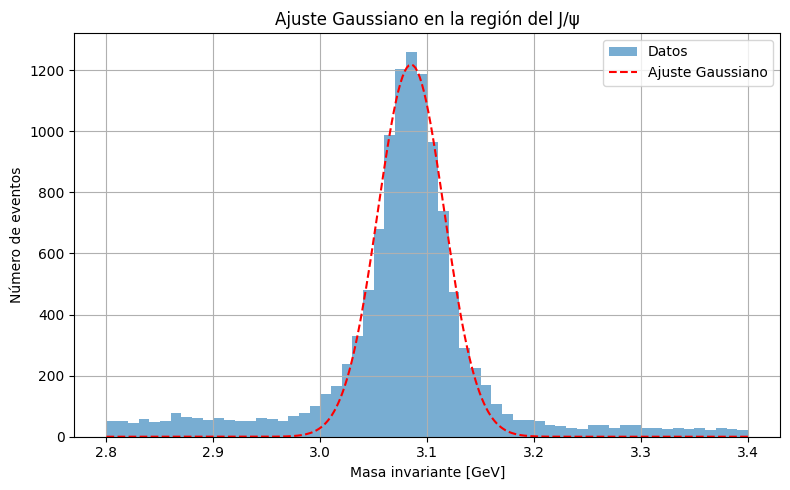

In [147]:

# Calcular masa invariante
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']
mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

# Filtrar región del J/ψ
region = particles[(particles['invariant_mass'] > 2.8) & (particles['invariant_mass'] < 3.4)]

# Histograma
hist_values, bin_edges = np.histogram(region['invariant_mass'], bins=60, range=(2.8, 3.4))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Función gaussiana
def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2 * sigma**2))

# Ajustar curva
popt, pcov = curve_fit(gaussian, bin_centers, hist_values, p0=[1000, 3.1, 0.05])
A, mu, sigma = popt
mu_err, sigma_err = np.sqrt(np.diag(pcov))[1:]

# Mostrar resultados del ajuste
print(f"Masa central (mu): {mu:.4f} ± {mu_err:.4f} GeV")
print(f"Ancho (sigma): {sigma:.4f} ± {sigma_err:.4f} GeV")

# Graficar histograma + ajuste
plt.figure(figsize=(8,5))
plt.hist(region['invariant_mass'], bins=60, range=(2.8, 3.4), alpha=0.6, label='Datos')
x_fit = np.linspace(2.8, 3.4, 300)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r--', label='Ajuste Gaussiano')
plt.title('Ajuste Gaussiano en la región del J/ψ')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

COMPARACION CON LOS DATOS DEL PDG, ENCONTRAR FILTROS PARA DISMINUIR EL WITHD

Masa central (mu): 3.0546 ± 0.0072 GeV
Ancho (sigma): 0.1134 ± 0.0075 GeV


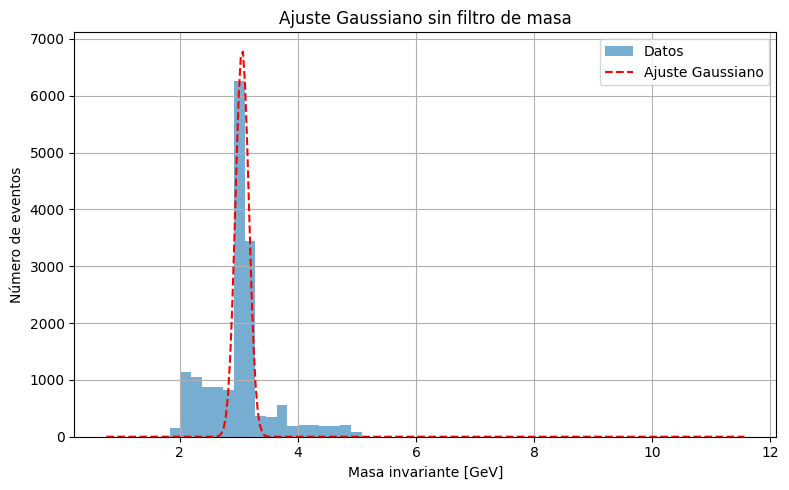

In [148]:

# Aplicar filtros: muones globales y de carga opuesta
filtered = particles[(particles['type1'] == 'G') & (particles['type2'] == 'G') & (particles['Q1'] * particles['Q2'] == -1)].copy()

# Calcular masa invariante para los eventos filtrados
delta_eta = filtered['eta1'] - filtered['eta2']
delta_phi = filtered['phi1'] - filtered['phi2']
mass_squared = 2 * filtered['pt1'] * filtered['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
filtered['invariant_mass'] = np.sqrt(mass_squared)



# Crear histograma
hist_values, bin_edges = np.histogram(filtered['invariant_mass'], bins=60)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Función gaussiana
def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2 * sigma**2))

# Ajuste gaussiano
popt, pcov = curve_fit(gaussian, bin_centers, hist_values, p0=[500, 3.1, 0.05])
A, mu, sigma = popt
mu_err, sigma_err = np.sqrt(np.diag(pcov))[1:]

# Mostrar resultados
print(f"Masa central (mu): {mu:.4f} ± {mu_err:.4f} GeV")
print(f"Ancho (sigma): {sigma:.4f} ± {sigma_err:.4f} GeV")

# Graficar
plt.figure(figsize=(8, 5))
plt.hist(filtered['invariant_mass'], bins=60, alpha=0.6, label='Datos')
x_fit = np.linspace(filtered['invariant_mass'].min(), filtered['invariant_mass'].max(), 300)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r--', label='Ajuste Gaussiano')
plt.title('Ajuste Gaussiano sin filtro de masa')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Masa central (mu): 3.0849 ± 0.0007 GeV
Ancho (sigma): 0.0305 ± 0.0007 GeV


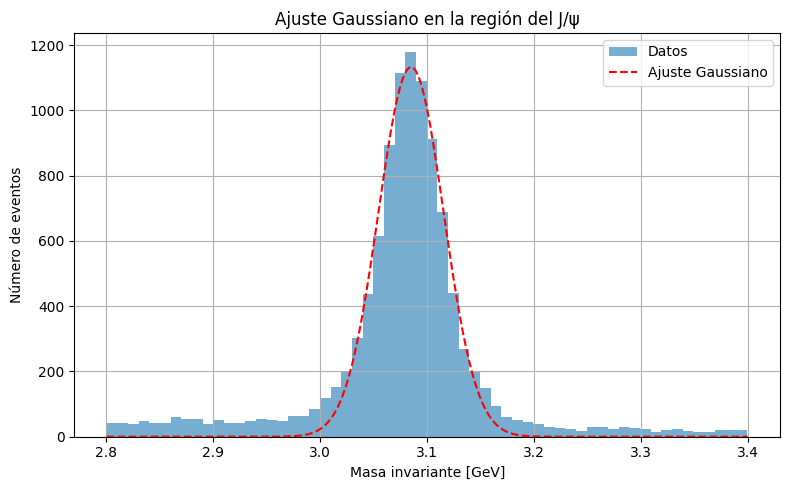

In [149]:
# Aplicar filtros: muones globales y de carga opuesta
filtered = particles[(particles['type1'] == 'G') & (particles['type2'] == 'G') & (particles['Q1'] * particles['Q2'] == -1)].copy()

# Calcular masa invariante para los eventos filtrados
delta_eta = filtered['eta1'] - filtered['eta2']
delta_phi = filtered['phi1'] - filtered['phi2']
mass_squared = 2 * filtered['pt1'] * filtered['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
filtered['invariant_mass'] = np.sqrt(mass_squared)

# ✅ Filtro por región de masa (ej. para J/ψ)
region = filtered[(filtered['invariant_mass'] > 2.8) & (filtered['invariant_mass'] < 3.4)].copy()

# Crear histograma
hist_values, bin_edges = np.histogram(region['invariant_mass'], bins=60)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Función gaussiana
def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2 * sigma**2))

# Ajuste gaussiano
popt, pcov = curve_fit(gaussian, bin_centers, hist_values, p0=[1000, 3.1, 0.05])
A, mu, sigma = popt
mu_err, sigma_err = np.sqrt(np.diag(pcov))[1:]

# Resultados
print(f"Masa central (mu): {mu:.4f} ± {mu_err:.4f} GeV")
print(f"Ancho (sigma): {sigma:.4f} ± {sigma_err:.4f} GeV")

# Graficar
plt.figure(figsize=(8, 5))
plt.hist(region['invariant_mass'], bins=60, alpha=0.6, label='Datos')
x_fit = np.linspace(2.8, 3.4, 300)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r--', label='Ajuste Gaussiano')
plt.title('Ajuste Gaussiano en la región del J/ψ')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

CONTINUACION DEL ANTERIOR GRAFICA

In [150]:

# Filtrado de eventos
filtered = particles[
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G') &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['pt1'] > 10) &
    (particles['pt2'] > 10) &
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4)
].copy()

# Calcular masa invariante
delta_eta = filtered['eta1'] - filtered['eta2']
delta_phi = filtered['phi1'] - filtered['phi2']
mass_squared = 2 * filtered['pt1'] * filtered['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
filtered['invariant_mass'] = np.sqrt(mass_squared)

# Mostrar cuántos eventos cumplen los filtros
print(f"Eventos después de todos los filtros: {len(filtered)}")

# Histograma con Plotly
fig = px.histogram(filtered, x='invariant_mass', nbins=80,
                   title='Masa invariante (muones Global-Global, pt>10 GeV, |η|<2.4, Q1·Q2 = -1)',
                   labels={'invariant_mass': 'Masa invariante [GeV]'})
fig.update_layout(bargap=0.05)
fig.show()

Eventos después de todos los filtros: 2718


Masa central (mu): 3.0836 ± 0.0018 GeV
Ancho (sigma): 0.0383 ± 0.0019 GeV


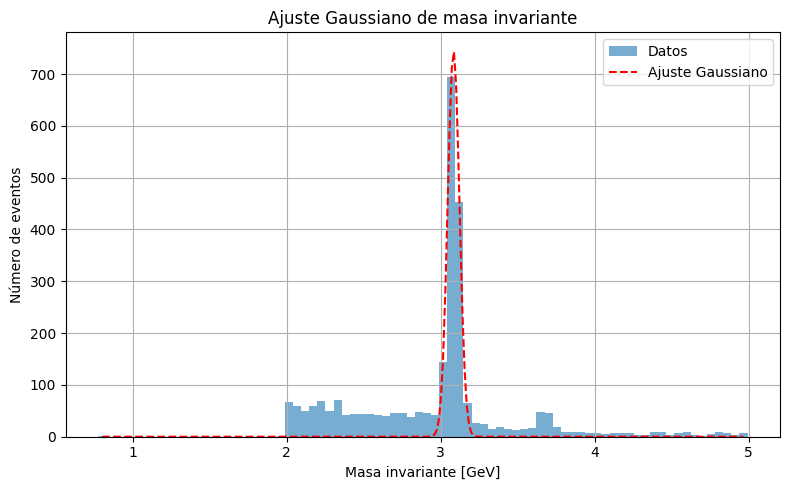

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Aplicar los filtros
filtered = particles[
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G') &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['pt1'] > 10) &
    (particles['pt2'] > 10) &
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4)
].copy()

# Calcular masa invariante
delta_eta = filtered['eta1'] - filtered['eta2']
delta_phi = filtered['phi1'] - filtered['phi2']
mass_squared = 2 * filtered['pt1'] * filtered['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
filtered['invariant_mass'] = np.sqrt(mass_squared)

# Crear histograma para ajustar
hist_values, bin_edges = np.histogram(filtered['invariant_mass'], bins=80)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Definir función gaussiana
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Ajustar la gaussiana
popt, pcov = curve_fit(gaussian, bin_centers, hist_values, p0=[500, 3.1, 0.05])
A, mu, sigma = popt
mu_err, sigma_err = np.sqrt(np.diag(pcov))[1:]

# Mostrar parámetros ajustados
print(f"Masa central (mu): {mu:.4f} ± {mu_err:.4f} GeV")
print(f"Ancho (sigma): {sigma:.4f} ± {sigma_err:.4f} GeV")

# Graficar histograma + ajuste
plt.figure(figsize=(8, 5))
plt.hist(filtered['invariant_mass'], bins=80, alpha=0.6, label='Datos')
x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 300)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r--', label='Ajuste Gaussiano')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Ajuste Gaussiano de masa invariante')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
